In [67]:
# First, import the relevant modules
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The inital data set was provided on Kaggle collected by jtrofe (https://www.kaggle.com/jtrofe/beer-recipes) and using data from www.Brewersfriend.com. The initial data provided in this data set was a robust starting point for this project. However, additional data was acquired to supplement this inital set of 73,800+ entries. The original data came in two .csv files. The first (recipeData.csv) contains most of the information on the homebrews. The second (styleData.csv) contains the assignment for the styles of beer found in the recipeData file.

The data acqusitition for my project is in two parts. The first part is scraping ratings data from the website using the Beautiful Soup package. The second part is to use the API to obtain recipe data (e.g. ingredients, hops, yeast, etc.) for each entry.

A few separate files used in this notebook have been augmented from the original data set. The first (recipeData_urls_all.csv) only contains all of the urls in the original recipeData.csv document. These entries specifically are the subdirectories pertaining to each beer in the dataset. The second (recipe_id.csv) is generated below in part two and contains a list of each of the recipe id harvested from the urls in the original recipeData.csv document. 

1) Data Acquisition of Ratings Data via Beautiful Soup

In [15]:
# Establish headers, the base_url (or domain), and a list to accept data from Beautiful Soup

headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.108 Safari/537.36'
}

base_url = 'https://www.brewersfriend.com'
data = [["url", "rating", "reviews", "calories", "carbs"]]

In [16]:
# Define a function to help sift through the soup: ladel

def ladle(url):
    # This function takes the url given and requests the rating, review, calories, and carbs of the beer in question.
    # The entry is appended to the defined list.
    
    beer_html = requests.get(url, headers=headers).text

    soup = BeautifulSoup(beer_html, 'html5lib')

    rating = soup.find('span', {'itemprop': 'ratingValue'}) if soup.find('span', {'itemprop': 'ratingValue'}) != None else "NaN"
    review = soup.find('span', {'itemprop': 'reviewCount'}) if soup.find('span', {'itemprop': 'reviewCount'}) != None else "NaN"
    calories = soup.find('strong', {'class': 'calories'}) if soup.find('strong', {'class': 'calories'}) != None else "NaN"
    carbs = soup.find('strong', {'class': 'carbs'}) if soup.find('strong', {'class': 'carbs'}) != None else "NaN"

    temp = [url, 
            rating.text if rating != "NaN" else 'NaN', 
            review.text if review != "NaN" else 'NaN', 
            calories.text if calories != "NaN" else 'NaN', 
            carbs.text if carbs != "NaN" else 'NaN']
    data.append(temp)
        
    return data

In [17]:
# A dataframe of the full url is generated for each url fragment in Kaggle data set.

url_df = pd.read_csv('recipeData_urls_all.csv', header= None, engine = 'python', encoding = 'ISO-8859-1').apply(lambda x: base_url + x)

print(url_df.tail(10))

                                                       0
73851  https://www.brewersfriend.com/homebrew/recipe/...
73852  https://www.brewersfriend.com/homebrew/recipe/...
73853  https://www.brewersfriend.com/homebrew/recipe/...
73854  https://www.brewersfriend.com/homebrew/recipe/...
73855  https://www.brewersfriend.com/homebrew/recipe/...
73856  https://www.brewersfriend.com/homebrew/recipe/...
73857  https://www.brewersfriend.com/homebrew/recipe/...
73858  https://www.brewersfriend.com/homebrew/recipe/...
73859  https://www.brewersfriend.com/homebrew/recipe/...
73860  https://www.brewersfriend.com/homebrew/recipe/...


In [ ]:
# Write a for loop: for each full url in the dataframe "url_df", perform the ladel function. This will build up a list: data
# included a counter to show the status of scraping 

counter = 0
for index, row in url_df.iterrows():
    ladle(row[0])
    counter += 1
    if counter % 500 == 0:
        print (counter)
    else:
        continue

In [6]:
# Convert the list "data" into a dataframe: df
# This step took about 7 hours to complete and was done in a separate Jupyter notebook with the same code.

df = pd.DataFrame(data)
print(df.tail())

                                                      0    1    2  \
3433  https://www.brewersfriend.com/homebrew/recipe/...  NaN  NaN   
3434  https://www.brewersfriend.com/homebrew/recipe/...  NaN  NaN   
3435  https://www.brewersfriend.com/homebrew/recipe/...  NaN  NaN   
3436  https://www.brewersfriend.com/homebrew/recipe/...  NaN  NaN   
3437  https://www.brewersfriend.com/homebrew/recipe/...  NaN  NaN   

                 3       4  
3433           NaN     NaN  
3434  159 calories  17.2 g  
3435  153 calories  14.8 g  
3436  206 calories  22.4 g  
3437  435 calories  29.3 g  


In [9]:
# Save the webscraped data as a csv file for later: reviewData_all.csv

df.to_csv('reviewData_all.csv')

From step one, we have available review data from most of the entries. This was limited by two factors. 

The first limitation was from the data itself. Only entries that have reviews and ratings at the time of scraping will be included.

The second limitation is the time required for this scraping to occur. Due to how large the data set is, I experienced problems
scraping due to TimeOut Errors with the server. This was possibly due to over-requesting and being rejected from the server end to 
avoid a crash. To remedy this, the web scraping occured overnight and I was able to get all the review data.


2) Data Acquisition of Ingredient Data via Brewer's Friend API

First, the recipe ID numbers need to be extracted from the recipeData.csv original dataset. 

In [18]:
url_df = pd.read_csv('recipeData_urls.csv', header= None, engine = 'python', encoding = 'ISO-8859-1')

print(url_df.tail(10))

                                                       0
73851          /homebrew/recipe/view/615556/blonde-stout
73852        /homebrew/recipe/view/618629/session-simcoe
73853  /homebrew/recipe/view/602248/chris-ford-wheat-ipa
73854  /homebrew/recipe/view/603016/x-files-american-ale
73855           /homebrew/recipe/view/607368/unicorn-pee
73856         /homebrew/recipe/view/609673/amber-alfie-2
73857               /homebrew/recipe/view/610955/rye-ipa
73858                      /homebrew/recipe/view/586891/
73859                      /homebrew/recipe/view/603788/
73860  /homebrew/recipe/view/613776/elvis-juice-ipa-c...


In [3]:
new_list = []
for index,row in url_df.iterrows():
    temp = row[0].rsplit('/')
    new_list.append(temp)
    
rec_df = pd.DataFrame(new_list)
print(rec_df.tail(10))

      0         1       2     3       4                      5
73851    homebrew  recipe  view  615556           blonde-stout
73852    homebrew  recipe  view  618629         session-simcoe
73853    homebrew  recipe  view  602248   chris-ford-wheat-ipa
73854    homebrew  recipe  view  603016   x-files-american-ale
73855    homebrew  recipe  view  607368            unicorn-pee
73856    homebrew  recipe  view  609673          amber-alfie-2
73857    homebrew  recipe  view  610955                rye-ipa
73858    homebrew  recipe  view  586891                       
73859    homebrew  recipe  view  603788                       
73860    homebrew  recipe  view  613776  elvis-juice-ipa-clone


In [4]:
# Getting only the column with the recipe ID's, 

rec_id = rec_df[[4]]
print(rec_id.head())

       4
0   1633
1  16367
2   5920
3   5916
4  89534


In [5]:
# The list of recipe_IDs is saved for future reference: 'recipe_id.csv'
rec_id.to_csv('recipe_id.csv')

Using the newly created list of recipe IDs, rec_id, the ingredient list API can now be set up.

In [6]:
# Establish new headers and base url (domain) for the recipe and ingredients

my_headers = {'X-API-KEY': '1062c1a3650672bb65e9dc8c71bd7dfe4061166f'}
base_rec_url = 'https://api.brewersfriend.com/v1/recipes/'

In [7]:
# Create five empty dataframes, one for each category of ingredient and place in a dictionary: ingredient_dict

fermentables = pd.DataFrame()
hops = pd.DataFrame()
misc = pd.DataFrame()
mash = pd.DataFrame()
yeast = pd.DataFrame()

ingredient_dict = {"FERMENTABLE": fermentables, "HOP": hops, "MISC": misc, 'MASH': mash,'YEAST': yeast}

In [8]:
# Define a function to help parse through xml data for each recipe: xml_sift()

def xml_sift(xml_file, recipe_id, xpath_loc, df):
    
    """ This function looks at the xml data from Brewer's Friend recipe API output, specifically looking at the Fermentables, Hops, 
    Misc, Mash Steps, and Yeast used and adds the value of Recipe ID in a new column. The MASH portion of the if-else statement is 
    needed because the xpath is unique compared to the other ingredients. The try-except clause is required to ignore recipes that 
    do not contain a given ingredient type (usually MISC values are missing).""" 
    
    if 'MASH' in xpath_loc:
        try:
            temp = pd.read_xml(xml_file, xpath = "/RECIPES/RECIPE/MASH/MASH_STEPS/MASH_STEP")
            temp.insert(0, "Recipe_ID", recipe_id, True)
            return temp
        except ValueError: 
            pass 
    else:
        try:
            temp = pd.read_xml(xml_file, xpath = "/RECIPES/RECIPE/" + xpath_loc + 'S/' + xpath_loc)
            temp.insert(0, "Recipe_ID", recipe_id, True)
            return temp
        except ValueError: 
            pass

In [9]:
# Define a function to get ingredient data for a given recipe: gather_ingredients()

def gather_ingredients(recipe_id):
    
    """This function uses the domain (base_rec_url) and the input recipe_id to request an xml using the API from
    Brewer's Friend (https://docs.brewersfriend.com/api/recipes). This function uses standard request.get to retrieve
    the xml file. This file cannot be converted into a json. The for loop works through each of the five ingredient
    types using the dictionary ingredient_dict. The results from xml_sift are concatenated onto the respective dataframe
    by adding rows under the previous recipe (axis = 0). 
    
    The subfunction '.reset_index()' was required to get this to work because otherwise we were rewriting index 0-5 multiple times.
    The try-except clause is used to acknowledge missing entries or xpaths passed from the previous function (e.g.
    entries that don't have MISC ingredients listed will be ignored)."""
    
    url = base_rec_url + str(recipe_id) + '.xml'

    r = requests.get(url, headers=my_headers)

    xml_file = r.text
    
    for ingredient in ingredient_dict:
        try: 
            ingredient_dict[ingredient] = pd.concat([ingredient_dict[ingredient], xml_sift(xml_file, recipe_id, ingredient, ingredient_dict[ingredient])], axis = 0, ignore_index = True, sort = False).reset_index(drop=True)
        except:
            continue
    

In [10]:
# Write a for loop: for each recipe ID in the dataframe "rec_id", perform the gather_ingredients function. 

for index, row in rec_id.iterrows():
    gather_ingredients(row[4])   

In [11]:
# Checking the shape of the FERMENTABLE dataframe 

print(ingredient_dict['FERMENTABLE'].shape)

(294096, 10)


In [12]:
# Save each of the dataframes in 'ingredient_dict' as a csv file

for k,v in ingredient_dict.items():
    ingredient_dict[k].to_csv(path_or_buf = k+'.csv', index=False)

From step two, we have five CSV files that each contain all of the ingredient data for each recipe saved (e.g. 'FERMENTABLE.CSV'). 

In the data wrangling component, using the six CSV files gathered here and the original data set, we'll go through and 
design the final data set that will be used for modeling. 


3) Analyzing Data that was Gathered: (Review Data)

For the first portion of the data cleaning, 

In [2]:
ferm_df = pd.read_csv('FERMENTABLE.csv')
print(ferm_df.head())

   Recipe_ID                   NAME  VERSION     TYPE    AMOUNT  YIELD  COLOR  \
0       1633             Pale 2-Row        1    Grain  2.381360  80.43    1.8   
1       1633            White Wheat        1    Grain  0.907185  86.96    2.8   
2       1633             Pale 6-Row        1    Grain  0.907185  76.09    1.8   
3       1633            Flaked Corn        1  Adjunct  0.226796  86.96    0.5   
4       1633  Caramel / Crystal 20L        1    Grain  0.226796  76.09   20.0   

   ADD_AFTER_BOIL         ORIGIN  DIASTATIC_POWER  
0           False  United States              0.0  
1           False  United States              0.0  
2           False  United States              0.0  
3           False            NaN              0.0  
4           False  United States              0.0  


In [3]:
unique_ferm = ferm_df['NAME'].unique()
print(unique_ferm)

['Pale 2-Row' 'White Wheat' 'Pale 6-Row' ... 'Dry Malt Extract - Pale Ale'
 'Best Malz Rye' 'JWM Traditional Ale Malt']


In [4]:
hops_df = pd.read_csv('HOP.csv')
print(hops_df.head())

   Recipe_ID      NAME  VERSION  ALPHA    AMOUNT   USE USER_HOP_USE  TIME  \
0       1633   Cascade        1    6.2  0.014175  Boil         Boil  60.0   
1       1633   Cascade        1    6.2  0.014175  Boil         Boil  20.0   
2       1633      saaz        1    3.0  0.014175  Boil         Boil   5.0   
3      16367    Magnum        1   15.0  0.028350  Boil         Boil  50.0   
4      16367  Sterling        1    8.7  0.028350  Boil         Boil  10.0   

     FORM  HOP_TEMP  UTILIZATION  TEMPERATURE  
0  Pellet       NaN          NaN          NaN  
1  Pellet       NaN          NaN          NaN  
2  Pellet       NaN          NaN          NaN  
3  Pellet       NaN          NaN          NaN  
4  Pellet       NaN          NaN          NaN  


In [5]:
unique_hops_df = hops_df['NAME'].unique()
unique_hops_df.shape

(3268,)

In [6]:
misc_df = pd.read_csv("MISC.csv")
print (misc_df.head())

   Recipe_ID                          NAME  VERSION    TYPE        USE  TIME  \
0       1633          pure vanilla extract        1  Flavor       Boil   0.0   
1       1633          pure vanilla extract        1  Flavor   Bottling   0.0   
2       1633                yeast nutrient        1   Other       Boil  15.0   
3       1633                     whirlfloc        1  Fining       Boil  15.0   
4       1633  Vanilla beans - in 2oz Vodka        1   Other  Secondary   0.0   

     AMOUNT  AMOUNT_IS_WEIGHT  
0  0.059147             False  
1  0.029574             False  
2  0.004929             False  
3  1.000000              True  
4  1.000000              True  


In [7]:
unique_misc_df = misc_df['NAME'].unique()
unique_misc_df.shape

(10255,)

In [8]:
yeast_df = pd.read_csv('YEAST.csv')
print(yeast_df.head())

   Recipe_ID                                NAME  VERSION TYPE    FORM  \
0       1633                         Kölsch 2565        1  Ale  Liquid   
1      16367                   American Ale 1056        1  Ale  Liquid   
2       5920     Safale - English Ale Yeast S-04        1  Ale     Dry   
3       5916     Safale - English Ale Yeast S-04        1  Ale     Dry   
4      89534  Safbrew - Specialty Ale Yeast T-58        1  Ale     Dry   

   AMOUNT PRODUCT_ID          LABORATORY  ATTENUATION FLOCCULATION  \
0    0.10       2565              Wyeast         76.0          Low   
1    0.10       1056              Wyeast         75.0       Medium   
2    0.11       S-04  Fermentis / Safale         75.0         High   
3    0.11       S-04  Fermentis / Safale         75.0         High   
4    0.11       T-58  Fermentis / Safale         80.0         High   

   MIN_TEMPERATURE  MAX_TEMPERATURE AMOUNT_IS_WEIGHT  
0        13.333333        21.111111              NaN  
1        15.555556      

In [9]:
unique_yeast_df = yeast_df['NAME'].unique()
unique_yeast_df.shape

(1727,)

In [68]:
recipe_df = pd.read_csv('recipeData.csv', engine = 'python', encoding = 'ISO-8859-1')
print(recipe_df.head())

   BeerID                             Name  \
0       1                Vanilla Cream Ale   
1       2      Southern Tier Pumking clone   
2       3      Zombie Dust Clone - EXTRACT   
3       4    Zombie Dust Clone - ALL GRAIN   
4       5  Bakke Brygg Belgisk Blonde 50 l   

                                                 URL  \
0       /homebrew/recipe/view/1633/vanilla-cream-ale   
1  /homebrew/recipe/view/16367/southern-tier-pumk...   
2  /homebrew/recipe/view/5920/zombie-dust-clone-e...   
3  /homebrew/recipe/view/5916/zombie-dust-clone-a...   
4  /homebrew/recipe/view/89534/bakke-brygg-belgis...   

                                Style  StyleID  Size(L)     OG     FG   ABV  \
0                           Cream Ale       45    21.77  1.055  1.013  5.48   
1  Holiday/Winter Special Spiced Beer       85    20.82  1.083  1.021  8.16   
2                        American IPA        7    18.93  1.063  1.018  5.91   
3                        American IPA        7    22.71  1.061  1.017 

In [69]:
id_df = pd.read_csv('recipe_id.csv')
print(id_df.head())

   Recipe ID
0       1633
1      16367
2       5920
3       5916
4      89534


In [70]:
recipe_ID_df = recipe_df.join(id_df['Recipe ID'])
print(recipe_ID_df.head())

   BeerID                             Name  \
0       1                Vanilla Cream Ale   
1       2      Southern Tier Pumking clone   
2       3      Zombie Dust Clone - EXTRACT   
3       4    Zombie Dust Clone - ALL GRAIN   
4       5  Bakke Brygg Belgisk Blonde 50 l   

                                                 URL  \
0       /homebrew/recipe/view/1633/vanilla-cream-ale   
1  /homebrew/recipe/view/16367/southern-tier-pumk...   
2  /homebrew/recipe/view/5920/zombie-dust-clone-e...   
3  /homebrew/recipe/view/5916/zombie-dust-clone-a...   
4  /homebrew/recipe/view/89534/bakke-brygg-belgis...   

                                Style  StyleID  Size(L)     OG     FG   ABV  \
0                           Cream Ale       45    21.77  1.055  1.013  5.48   
1  Holiday/Winter Special Spiced Beer       85    20.82  1.083  1.021  8.16   
2                        American IPA        7    18.93  1.063  1.018  5.91   
3                        American IPA        7    22.71  1.061  1.017 

In [71]:
review_df = pd.read_csv('reviewData_all.csv', engine = 'python', encoding = 'ISO-8859-1')
print(review_df.head())

                                                 url  rating  reviews  \
0  https://www.brewersfriend.com/homebrew/recipe/...    4.78     18.0   
1  https://www.brewersfriend.com/homebrew/recipe/...    4.69     16.0   
2  https://www.brewersfriend.com/homebrew/recipe/...    4.67      9.0   
3  https://www.brewersfriend.com/homebrew/recipe/...    4.70     10.0   
4  https://www.brewersfriend.com/homebrew/recipe/...    3.80      5.0   

       calories   carbs  
0  181 calories  18.2 g  
1  277 calories  28.6 g  
2  209 calories  21.8 g  
3  202 calories  21.5 g  
4  189 calories  17.2 g  


In [72]:
fix this
1 no cal
2 url long or remove url long
3 no g

SyntaxError: invalid syntax (<ipython-input-72-eb2523ff970d>, line 1)

In [73]:
calories_with_units = review_df[['calories']]
calories_with_units.columns = ['Calories']
print(calories_with_units)

           Calories
0      181 calories
1      277 calories
2      209 calories
3      202 calories
4      189 calories
...             ...
73856  159 calories
73857  179 calories
73858  139 calories
73859  132 calories
73860  182 calories

[73861 rows x 1 columns]


In [74]:
calories_no_units = []
for index, row in calories_with_units.iterrows():
#    if calories_with_units[i]  'NaN':
    temp = calories_with_units.str[:4] #maybe try .strip if this doesn't work?
    calories_no_units.append(temp)
#    else:
#        calories_no_units = 0
#    print(calories_with_units[i])#.removesuffix(' calories') #maybe try .strip if this doesn't work?



AttributeError: 'DataFrame' object has no attribute 'str'

In [75]:
carbs_with_units = review_df.carbs
carbs_no_units = carbs_with_units.removesuffix(' g') #maybe try .strip if this doesn't work?
#review_df['calories'] = float(calories_no_units)  , wait until the previous steps work

AttributeError: 'Series' object has no attribute 'removesuffix'

In [76]:
review_no_url_df = review_df.drop('url', axis=1)

In [77]:
review_no_url_df.head()

,rating,reviews,calories,carbs
0,4.78,18.0,181 calories,18.2 g
1,4.69,16.0,277 calories,28.6 g
2,4.67,9.0,209 calories,21.8 g
3,4.70,10.0,202 calories,21.5 g
4,3.80,5.0,189 calories,17.2 g


In [78]:
recipe_ID_review_df = pd.concat([recipe_ID_df, review_no_url_df], axis = 1)
print(recipe_ID_review_df) 

       BeerID                             Name  \
0           1                Vanilla Cream Ale   
1           2      Southern Tier Pumking clone   
2           3      Zombie Dust Clone - EXTRACT   
3           4    Zombie Dust Clone - ALL GRAIN   
4           5  Bakke Brygg Belgisk Blonde 50 l   
...       ...                              ...   
73856   73857                    Amber Alfie 2   
73857   73858                          Rye IPA   
73858   73859                        SK-Kölsch   
73859   73860                  Flata Rødkløver   
73860   73861            Elvis Juice IPA Clone   

                                                     URL  \
0           /homebrew/recipe/view/1633/vanilla-cream-ale   
1      /homebrew/recipe/view/16367/southern-tier-pumk...   
2      /homebrew/recipe/view/5920/zombie-dust-clone-e...   
3      /homebrew/recipe/view/5916/zombie-dust-clone-a...   
4      /homebrew/recipe/view/89534/bakke-brygg-belgis...   
...                                    

In [79]:
# Save the combined data as a csv file for later: ___Data_all.csv

recipe_ID_review_df.to_csv('recipe_id_review_Data_all.csv')

In [80]:
recipe_ID_review_df.head()

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,...,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId,Recipe ID,rating,reviews,calories,carbs
0,1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,...,NaN,17.78,corn sugar,4.5 oz,116.0,1633,4.78,18.0,181 calories,18.2 g
1,2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,...,NaN,NaN,NaN,NaN,955.0,16367,4.69,16.0,277 calories,28.6 g
2,3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,...,NaN,NaN,NaN,NaN,NaN,5920,4.67,9.0,209 calories,21.8 g
3,4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,...,NaN,NaN,NaN,NaN,NaN,5916,4.70,10.0,202 calories,21.5 g
4,5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,...,NaN,19.00,Sukkerlake,6-7 g sukker/l,18325.0,89534,3.80,5.0,189 calories,17.2 g


In [81]:
refined_recipe_df = recipe_ID_review_df[recipe_ID_review_df['rating'].notna()]

In [82]:
refined_recipe_df.head()
refined_recipe_df.shape

(2192, 28)

In [83]:
# Save the refined data as a csv file for later: ___Data_refined.csv

refined_recipe_df.to_csv('recipe_id_review_Data_refined.csv')

In [84]:
refined_recipe_df_= pd.read_csv('recipe_id_review_Data_refined.csv')
print(refined_recipe_df.head())

   BeerID                             Name  \
0       1                Vanilla Cream Ale   
1       2      Southern Tier Pumking clone   
2       3      Zombie Dust Clone - EXTRACT   
3       4    Zombie Dust Clone - ALL GRAIN   
4       5  Bakke Brygg Belgisk Blonde 50 l   

                                                 URL  \
0       /homebrew/recipe/view/1633/vanilla-cream-ale   
1  /homebrew/recipe/view/16367/southern-tier-pumk...   
2  /homebrew/recipe/view/5920/zombie-dust-clone-e...   
3  /homebrew/recipe/view/5916/zombie-dust-clone-a...   
4  /homebrew/recipe/view/89534/bakke-brygg-belgis...   

                                Style  StyleID  Size(L)     OG     FG   ABV  \
0                           Cream Ale       45    21.77  1.055  1.013  5.48   
1  Holiday/Winter Special Spiced Beer       85    20.82  1.083  1.021  8.16   
2                        American IPA        7    18.93  1.063  1.018  5.91   
3                        American IPA        7    22.71  1.061  1.017 

In [85]:
refined_recipe_df.head()
refined_recipe_df.shape

(2192, 28)

In [86]:
len(refined_recipe_df['Name'].unique())

2113

In [87]:
refined_recipe_df['Name'].value_counts()

Awesome Recipe                             6
Citra IPA                                  5
Porter                                     5
IPA                                        4
Cream Ale                                  4
                                          ..
Goose island county bourbon stout clone    1
Strawberry chocolate wheat                 1
Rebel                                      1
2015 - 4/4 - Sherlocks Irish Red v3        1
Oregon-and-on-and-on Pacific NW IPA        1
Name: Name, Length: 2113, dtype: int64

In [88]:
print(len(refined_recipe_df['Style'].unique()))
print(refined_recipe_df['Style'].value_counts())

146
American IPA                    421
American Pale Ale               201
Imperial IPA                     69
American Amber Ale               56
Saison                           53
                               ... 
Kellerbier: Amber Kellerbier      1
Irish Extra Stout                 1
Wee Heavy                         1
Common Cider                      1
Kellerbier: Pale Kellerbier       1
Name: Style, Length: 145, dtype: int64


In [89]:
val_counts = refined_recipe_df['Style'].value_counts()
val_counts_df = val_counts.to_frame()
val_counts_df.columns = ['Count']
#print(val_counts_df)
val_count3_df = val_counts_df.query('Count > 2')

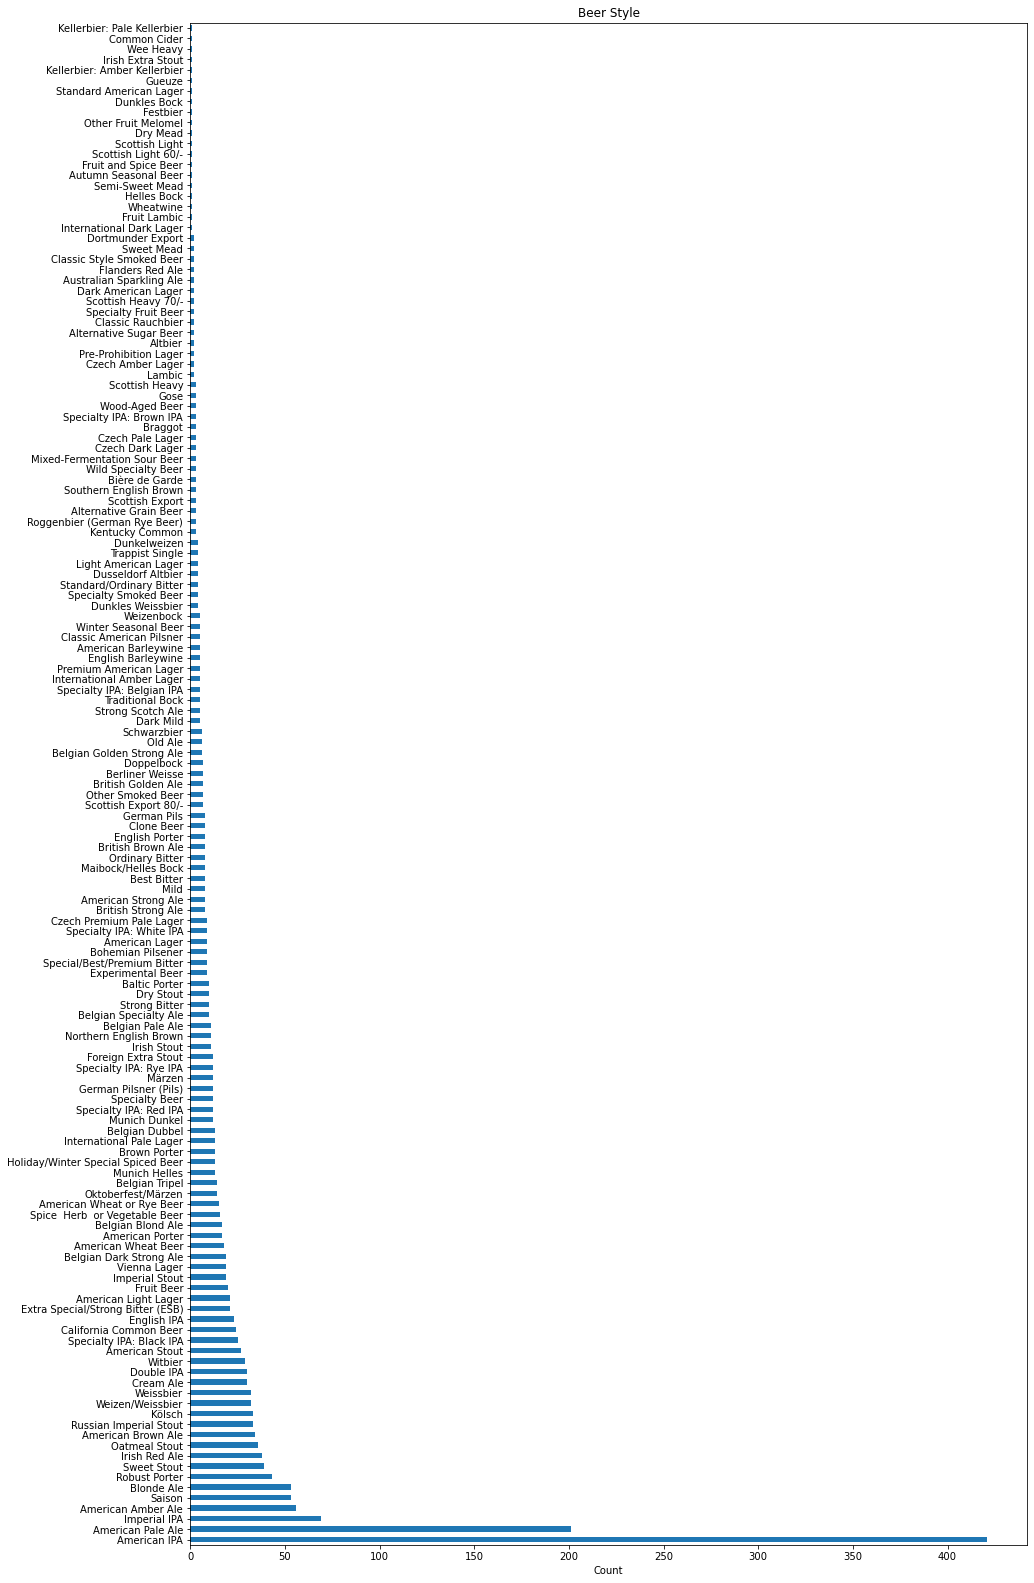

In [90]:
fig, ax = plt.subplots()
#Specify a horizontal barplot ('barh') as kind of plot (kind=)
refined_recipe_df.Style.value_counts().plot(kind='barh', figsize=(15, 28))

ax.set_title('Beer Style')

ax.set_xlabel('Count')

plt.subplots_adjust(wspace=0.5);

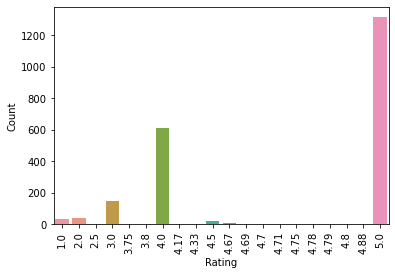

In [94]:
sns.countplot(x='rating', data=refined_recipe_df)
plt.xticks(rotation='vertical')
plt.xlabel('Rating')
plt.ylabel('Count');

In order to integrade the ingredient data, classes were developed. 

Below are the steps taken to gather that information

First, unique ingredient tables were extracted from each of the ingredient tables. The first example is taking each of the unique fermentables out of the fermentables table. The same process was done for the hops, misc, and yeast data.

In [2]:
ferm_df = pd.read_csv('FERMENTABLE.csv')

In [3]:
unique_ferm = ferm_df['NAME'].unique()

In [4]:
x = 0
ferm_recipe = [['Fermentable_Ingredient', 'Fermentable_ID', 'In_Recipes']]

In [5]:
for i in range(len(unique_ferm)):
    ferm_id = i
    ferm_name = unique_ferm[i]
    ferm_in_recipes = []
    all_recipes = ferm_df['Recipe_ID'].where(ferm_df['NAME'] == unique_ferm[i], other = 0)

    for j in range(len(all_recipes)):
        if all_recipes[j] != 0:
            if all_recipes[j] not in ferm_in_recipes:
                ferm_in_recipes.append(all_recipes[j])
    temp = [ferm_name, ferm_id, ferm_in_recipes]
    ferm_recipe.append(temp)

    x += 1
    if x % 5 == 0:
        print("Just processed unique fermentable #" +str(x))

Just processed unique fermentable #5
Just processed unique fermentable #10
Just processed unique fermentable #15
Just processed unique fermentable #20
Just processed unique fermentable #25
Just processed unique fermentable #30
Just processed unique fermentable #35
Just processed unique fermentable #40
Just processed unique fermentable #45
Just processed unique fermentable #50
Just processed unique fermentable #55
Just processed unique fermentable #60
Just processed unique fermentable #65
Just processed unique fermentable #70
Just processed unique fermentable #75
Just processed unique fermentable #80
Just processed unique fermentable #85
Just processed unique fermentable #90
Just processed unique fermentable #95
Just processed unique fermentable #100
Just processed unique fermentable #105
Just processed unique fermentable #110
Just processed unique fermentable #115
Just processed unique fermentable #120
Just processed unique fermentable #125
Just processed unique fermentable #130
Just p

In [6]:
ferm_recipe_df = pd.DataFrame(ferm_recipe)
print(ferm_recipe_df.tail())

                                0     1         2
3966   American - Blackprinz Malt  3965  [619851]
3967       SUPERIOR PALE ALE MALT  3966  [609931]
3968  Dry Malt Extract - Pale Ale  3967  [615080]
3969                Best Malz Rye  3968  [620886]
3970     JWM Traditional Ale Malt  3969  [620886]


In [7]:
print(ferm_recipe_df.head())

                        0               1  \
0  Fermentable_Ingredient  Fermentable_ID   
1              Pale 2-Row               0   
2             White Wheat               1   
3              Pale 6-Row               2   
4             Flaked Corn               3   

                                                   2  
0                                         In_Recipes  
1  [1633, 16367, 5916, 28546, 37534, 672, 29265, ...  
2  [1633, 23436, 392896, 322780, 310952, 25071, 1...  
3  [1633, 45045, 39013, 333744, 29714, 13785, 164...  
4  [1633, 672, 23436, 96572, 637, 92543, 10545, 3...  


In [8]:
# save the data
ferm_recipe_df.to_csv('unique_ferm_table_raw.csv')

In [11]:
ferm_recipe_df.shape

(3971, 3)

In [12]:
ferm_recipe_df.head()

,0,1,2
0,Fermentable_Ingredient,Fermentable_ID,In_Recipes
1,Pale 2-Row,0,"[1633, 16367, 5916, 28546, 37534, 672, 29265, ..."
2,White Wheat,1,"[1633, 23436, 392896, 322780, 310952, 25071, 1..."
3,Pale 6-Row,2,"[1633, 45045, 39013, 333744, 29714, 13785, 164..."
4,Flaked Corn,3,"[1633, 672, 23436, 96572, 637, 92543, 10545, 3..."


In [13]:
ferm_recipe_df.tail(10)

,0,1,2
3961,Raw Barley,3960,[614664]
3962,Gas Hog Rice Malt,3961,[588315]
3963,Amber Rice Malt,3962,[588315]
3964,Ireland - Ale Malt,3963,[620065]
3965,Home Smoked Vienna Malt. (cherry wood),3964,[620330]
3966,American - Blackprinz Malt,3965,[619851]
3967,SUPERIOR PALE ALE MALT,3966,[609931]
3968,Dry Malt Extract - Pale Ale,3967,[615080]
3969,Best Malz Rye,3968,[620886]
3970,JWM Traditional Ale Malt,3969,[620886]


In [15]:
new_header = ferm_recipe_df.iloc[0] #grab the first row for the header
ferm_recipe_df = ferm_recipe_df[1:] #take the data less the header row
ferm_recipe_df.columns = new_header #set the header row as the df header

In [16]:
ferm_recipe_df.head()

,Fermentable_Ingredient,Fermentable_ID,In_Recipes
1,Pale 2-Row,0,"[1633, 16367, 5916, 28546, 37534, 672, 29265, ..."
2,White Wheat,1,"[1633, 23436, 392896, 322780, 310952, 25071, 1..."
3,Pale 6-Row,2,"[1633, 45045, 39013, 333744, 29714, 13785, 164..."
4,Flaked Corn,3,"[1633, 672, 23436, 96572, 637, 92543, 10545, 3..."
5,Caramel / Crystal 20L,4,"[1633, 61082, 23246, 3837, 231072, 2742, 27718..."


In [17]:
# save the data
ferm_recipe_df.to_csv('unique_ferm_table.csv')

In [2]:
hops_df = pd.read_csv('HOP.csv')

In [3]:
unique_hops = hops_df['NAME'].unique()

In [4]:
y = 0
hops_recipe = [['Hop_Ingredient', 'Hop_ID', 'In_Recipes']]

In [5]:
for i in range(len(unique_hops)):
    hop_id = i
    hop_name = unique_hops[i]
    hop_in_recipes = []
    all_recipes = hops_df['Recipe_ID'].where(hops_df['NAME'] == unique_hops[i], other = 0)

    for j in range(len(all_recipes)):
        if all_recipes[j] != 0:
            if all_recipes[j] not in hop_in_recipes:
                hop_in_recipes.append(all_recipes[j])
    temp = [hop_name, hop_id, hop_in_recipes]
    hops_recipe.append(temp)

    y += 1
    if y % 5 == 0:
        print("Just processed unique hop #" +str(y))

Just processed unique hop #5
Just processed unique hop #10
Just processed unique hop #15
Just processed unique hop #20
Just processed unique hop #25
Just processed unique hop #30
Just processed unique hop #35
Just processed unique hop #40
Just processed unique hop #45
Just processed unique hop #50
Just processed unique hop #55
Just processed unique hop #60
Just processed unique hop #65
Just processed unique hop #70
Just processed unique hop #75
Just processed unique hop #80
Just processed unique hop #85
Just processed unique hop #90
Just processed unique hop #95
Just processed unique hop #100
Just processed unique hop #105
Just processed unique hop #110
Just processed unique hop #115
Just processed unique hop #120
Just processed unique hop #125
Just processed unique hop #130
Just processed unique hop #135
Just processed unique hop #140
Just processed unique hop #145
Just processed unique hop #150
Just processed unique hop #155
Just processed unique hop #160
Just processed unique hop #1

In [6]:
hops_recipe_df = pd.DataFrame(hops_recipe)
print(hops_recipe_df.tail())

                                  0     1         2
3264  Mosaic (12.3 AA) / 0.5 Ounces  3263  [619851]
3265             Galaxy (1/2 batch)  3264  [620582]
3266            Cascade (1/2 batch)  3265  [620582]
3267                Mos-cen-dor-sim  3266  [620714]
3268               experimental 035  3267  [610955]


In [7]:
hops_recipe_df.shape

(3269, 3)

In [8]:
# save the raw data
hops_recipe_df.to_csv('unique_hops_table_raw.csv')

In [9]:
hops_recipe_df.head()

,0,1,2
0,Hop_Ingredient,Hop_ID,In_Recipes
1,Cascade,0,"[1633, 28546, 672, 10092, 23246, 106996, 8361,..."
2,saaz,1,"[1633, 315890, 114504, 6274, 25558, 42136, 217..."
3,Magnum,2,"[16367, 28546, 61082, 23436, 1435, 89253, 4374..."
4,Sterling,3,"[16367, 31908, 5154, 4506, 20243, 27163, 8599,..."


In [10]:
new_header = hops_recipe_df.iloc[0] #grab the first row for the header
hops_recipe_df = hops_recipe_df[1:] #take the data less the header row
hops_recipe_df.columns = new_header #set the header row as the df header

In [11]:
hops_recipe_df.head()

,Hop_Ingredient,Hop_ID,In_Recipes
1,Cascade,0,"[1633, 28546, 672, 10092, 23246, 106996, 8361,..."
2,saaz,1,"[1633, 315890, 114504, 6274, 25558, 42136, 217..."
3,Magnum,2,"[16367, 28546, 61082, 23436, 1435, 89253, 4374..."
4,Sterling,3,"[16367, 31908, 5154, 4506, 20243, 27163, 8599,..."
5,Citra,4,"[5920, 5916, 61082, 73890, 8361, 363082, 29589..."


In [12]:
# save the data
hops_recipe_df.to_csv('unique_hops_table.csv')

In [13]:
yeast_df = pd.read_csv('YEAST.csv')

In [14]:
unique_yeast = yeast_df['NAME'].unique()

In [15]:
z = 0
yeast_recipe = [['Yeast_Ingredient', 'Yeast_ID', 'In_Recipes']]

In [16]:
for i in range(len(unique_yeast)):
    yeast_id = i
    yeast_name = unique_yeast[i]
    yeast_in_recipes = []
    all_recipes = yeast_df['Recipe_ID'].where(yeast_df['NAME'] == unique_yeast[i], other = 0)

    for j in range(len(all_recipes)):
        if all_recipes[j] != 0:
            if all_recipes[j] not in yeast_in_recipes:
                yeast_in_recipes.append(all_recipes[j])
    temp = [yeast_name, yeast_id, yeast_in_recipes]
    yeast_recipe.append(temp)

    z += 1
    if z % 5 == 0:
        print("Just processed unique yeast #" +str(z))

Just processed unique hop #5
Just processed unique hop #10
Just processed unique hop #15
Just processed unique hop #20
Just processed unique hop #25
Just processed unique hop #30
Just processed unique hop #35
Just processed unique hop #40
Just processed unique hop #45
Just processed unique hop #50
Just processed unique hop #55
Just processed unique hop #60
Just processed unique hop #65
Just processed unique hop #70
Just processed unique hop #75
Just processed unique hop #80
Just processed unique hop #85
Just processed unique hop #90
Just processed unique hop #95
Just processed unique hop #100
Just processed unique hop #105
Just processed unique hop #110
Just processed unique hop #115
Just processed unique hop #120
Just processed unique hop #125
Just processed unique hop #130
Just processed unique hop #135
Just processed unique hop #140
Just processed unique hop #145
Just processed unique hop #150
Just processed unique hop #155
Just processed unique hop #160
Just processed unique hop #1

In [17]:
yeast_recipe_df = pd.DataFrame(yeast_recipe)
print(yeast_recipe_df.tail())

                                0     1         2
1723  WLP001 California Ale Yeast  1722  [411539]
1724            RVA 101 Chico Ale  1723  [620136]
1725     Wyeast American Ale 1056  1724  [464297]
1726                 Wyeast Lacto  1725  [620294]
1727                   Brett brux  1726  [620582]


In [18]:
yeast_recipe_df.shape

(1728, 3)

In [19]:
# save the raw data
yeast_recipe_df.to_csv('unique_yeast_table_raw.csv')

In [20]:
yeast_recipe_df.head()

,0,1,2
0,Yeast_Ingredient,Yeast_ID,In_Recipes
1,Kölsch 2565,0,"[1633, 672, 190809, 81095, 189398, 82576, 1936..."
2,American Ale 1056,1,"[16367, 37534, 106996, 3837, 28344, 191545, 21..."
3,Safale - English Ale Yeast S-04,2,"[5920, 5916, 6549, 114849, 15664, 8459, 196008..."
4,Safbrew - Specialty Ale Yeast T-58,3,"[89534, 130561, 3381, 200470, 249305, 4136, 10..."


In [21]:
new_header = yeast_recipe_df.iloc[0] #grab the first row for the header
yeast_recipe_df = yeast_recipe_df[1:] #take the data less the header row
yeast_recipe_df.columns = new_header #set the header row as the df header

In [22]:
yeast_recipe_df.head()

,Yeast_Ingredient,Yeast_ID,In_Recipes
1,Kölsch 2565,0,"[1633, 672, 190809, 81095, 189398, 82576, 1936..."
2,American Ale 1056,1,"[16367, 37534, 106996, 3837, 28344, 191545, 21..."
3,Safale - English Ale Yeast S-04,2,"[5920, 5916, 6549, 114849, 15664, 8459, 196008..."
4,Safbrew - Specialty Ale Yeast T-58,3,"[89534, 130561, 3381, 200470, 249305, 4136, 10..."
5,Safale - American Ale Yeast US-05,4,"[28546, 73890, 318315, 189197, 16156, 227462, ..."


In [23]:
# save the data
yeast_recipe_df.to_csv('unique_yeast_table.csv')

In [24]:
misc_df = pd.read_csv('MISC.csv')

In [25]:
unique_misc = misc_df['NAME'].unique()

In [26]:
w = 0
misc_recipe = [['Misc_Ingredient', 'Misc_ID', 'In_Recipes']]

In [29]:
for i in range(len(unique_misc)):
    misc_id = i
    misc_name = unique_misc[i]
    misc_in_recipes = []
    all_recipes = misc_df['Recipe_ID'].where(misc_df['NAME'] == unique_misc[i], other = 0)

    for j in range(len(all_recipes)):
        if all_recipes[j] != 0:
            if all_recipes[j] not in misc_in_recipes:
                misc_in_recipes.append(all_recipes[j])
    temp = [misc_name, misc_id, misc_in_recipes]
    misc_recipe.append(temp)

    w += 1
    if w % 5 == 0:
        print("Just processed unique misc item #" +str(w))

Just processed unique misc item #5
Just processed unique misc item #10
Just processed unique misc item #15
Just processed unique misc item #20
Just processed unique misc item #25
Just processed unique misc item #30
Just processed unique misc item #35
Just processed unique misc item #40
Just processed unique misc item #45
Just processed unique misc item #50
Just processed unique misc item #55
Just processed unique misc item #60
Just processed unique misc item #65
Just processed unique misc item #70
Just processed unique misc item #75
Just processed unique misc item #80
Just processed unique misc item #85
Just processed unique misc item #90
Just processed unique misc item #95
Just processed unique misc item #100
Just processed unique misc item #105
Just processed unique misc item #110
Just processed unique misc item #115
Just processed unique misc item #120
Just processed unique misc item #125
Just processed unique misc item #130
Just processed unique misc item #135
Just processed unique

In [30]:
misc_recipe_df = pd.DataFrame(misc_recipe)
print(misc_recipe_df.tail())

                      0      1         2
10251   Pineapple puree  10250  [620222]
10252  Pineapple flavor  10251  [620222]
10253    Coconut flavor  10252  [620222]
10254      fresh Ginger  10253  [620522]
10255   Burton crystals  10254  [609673]


In [31]:
misc_recipe_df.shape

(10256, 3)

In [32]:
# save the raw data
misc_recipe_df.to_csv('unique_misc_table_raw.csv')

In [33]:
misc_recipe_df.head()

,0,1,2
0,Misc_Ingredient,Misc_ID,In_Recipes
1,pure vanilla extract,0,"[1633, 29265, 184479, 33619, 113581, 168618, 4..."
2,yeast nutrient,1,"[1633, 672, 29265, 14441, 20262, 23984, 2454, ..."
3,whirlfloc,2,"[1633, 672, 14478, 57961, 255745, 2873, 123552..."
4,Vanilla beans - in 2oz Vodka,3,"[1633, 373599]"


In [34]:
new_header = misc_recipe_df.iloc[0] #grab the first row for the header
misc_recipe_df = misc_recipe_df[1:] #take the data less the header row
misc_recipe_df.columns = new_header #set the header row as the df header

In [35]:
misc_recipe_df.head()

,Misc_Ingredient,Misc_ID,In_Recipes
1,pure vanilla extract,0,"[1633, 29265, 184479, 33619, 113581, 168618, 4..."
2,yeast nutrient,1,"[1633, 672, 29265, 14441, 20262, 23984, 2454, ..."
3,whirlfloc,2,"[1633, 672, 14478, 57961, 255745, 2873, 123552..."
4,Vanilla beans - in 2oz Vodka,3,"[1633, 373599]"
5,Demerara sugar,4,"[16367, 18679, 377765, 522938, 504862]"


In [36]:
# save the data
misc_recipe_df.to_csv('unique_misc_table.csv')

Classes were developed to help integrate the ingredient data.

In [22]:
class Fermentable:
    
#    id = 0
    recipe_array = []
    percent_bill = 0
    main_ingredient = False
    
    def __init__(self, name, amount):
        self.name = name
        self.amount = amount
        
    def __str__(self):
        if self.main_ingredient == False:
            print(str(self.name) + ' is not the main ingredient. Percentage is ' + str(self.percent_bill) + '%.')
        else:
            print(str(self.name) + ' is the main ingredient. Percentage is ' + str(self.percent_bill) + '%.')
    
    def set_name(self, new_name):
        self.name = new_name
    
    def set_amount(self, new_amount):
        self.amount = new_amount
    
    def set_id(self, new_id):
        self.id = new_id
        
    def set_recipe_array(self, new_recipe_array):
        self.recipe_array = new_recipe_array
    
    def set_percent_bill(self, new_percent_bill):
        self.percent_bill = new_percent_bill
    
    def set_main_ingredient(self, new_main_ingredient):
        self.main_ingredient = new_main_ingredient
        
        
    def get_name(self):
        return self.name
    
    def get_amount(self):
        return self.amount
    
    def get_id(self):
        return self.id
        
    def get_recipe_array(self):
        return self.recipe_array
    
    def get_percent_bill(self):
        return self.percent_bill
    
    def get_main_ingredient(self):
        return self.main_ingredient

In [23]:
class Hops:
    
#   id = 0
    recipe_array = []
   
    def __init__(self, name, amount, alpha):
        self.name = name
        self.amount = amount
        self.alpha = alpha
    
    def __str__(self):
        return 'This hops is ' + str(self.name) + ' and has ' + str(self.amount) + ' amount and ' + str(self.alpha) + ' alpha.'
    
    def set_name(self, new_name):
        self.name = new_name
    
    def set_amount(self, new_amount):
        self.amount = new_amount
    
    def set_id(self, new_id):
        self.id = new_id
        
    def set_recipe_array(self, new_recipe_array):
        self.recipe_array = new_recipe_array
    
    def set_alpha(self, new_alpha):
        self.alpha = new_alpha
        
        
    def get_name(self):
        return self.name
    
    def get_amount(self):
        return self.amount
    
    def get_id(self):
        return self.id
        
    def get_recipe_array(self):
        return self.recipe_array
    
    def get_alpha(self):
        return self.alpha

In [24]:
class Yeast:
    
#    id = 0
    recipe_array = []
   
    def __init__(self, name, laboratory, flocculation, form):
        self.name = name
        self.laboratory = laboratory
        self.flocculation = flocculation
        self.form = form
    
    def set_name(self, new_name):
        self.name = new_name
    
    def set_laboratory(self, new_laboratory):
        self.laboratory = new_laboratory
    
    def set_id(self, new_id):
        self.id = new_id
        
    def set_recipe_array(self, new_recipe_array):
        self.recipe_array = new_recipe_array
    
    def set_flocculation(self, new_flocculation):
        self.flocculation = new_flocculation
   
    def set_form(self, new_form):
        self.form = new_form        
        
        
    def get_name(self):
        return self.name
    
    def get_laboratory(self):
        return self.laboratory
    
    def get_id(self):
        return self.id
        
    def get_recipe_array(self):
        return self.recipe_array
    
    def get_flocculation(self):
        return self.flocculation
   
    def get_form(self):
        return self.form

In [25]:
class Misc:
   
    def __init__(self, name, amount, id, recipe_array):
        self.name = name
        self.amount = amount
        self.id = id
        self.recipe_array = recipe_array
    
    
    def set_name(self, new_name):
        self.name = new_name
    
    def set_amount(self, new_amount):
        self.amount = new_amount
    
    def set_id(self, new_id):
        self.id = new_id
        
    def set_recipe_array(self, new_recipe_array):
        self.recipe_array = new_recipe_array
    
        
    def get_name(self):
        return self.name
    
    def get_amount(self):
        return self.amount
    
    def get_id(self):
        return self.id
        
    def get_recipe_array(self):
        return self.recipe_array

In [26]:
class Recipe:
    
    fermentable = []
    hops = []
    yeast = []
   
    def __init__(self, name, id, rating):
        self.name = name
        self.id = id
        self.rating = rating
        
    def __str__(self):
        return 'This recipe is ' + str(self.name) + ' and has the ID ' + str(self.id) + ' and rating ' + str(self.rating) + '. It has ' + str(len(self.fermentable)) + ' fermentables, ' + str(len(self.hops)) + ' hops, and the yeast is ' + str(self.yeast.name) + '.'
    
    def set_name(self, new_name):
        self.name = new_name
    
    def set_amount(self, new_amount):
        self.amount = new_amount
    
    def set_id(self, new_id):
        self.id = new_id
        
    def set_rating(self, new_rating):
        self.rating = new_rating
    
    def set_fermentable(self, new_fermentable):
        self.fermentable = new_fermentable

    def set_hops(self, new_hops):
        self.hops = new_hops
 
    def set_yeast(self, new_yeast):
        self.yeast = new_yeast
      
    
    def get_name(self):
        return self.name
    
    def get_amount(self):
        return self.amount
    
    def get_id(self):
        return self.id
        
    def get_rating(self):
        return self.rating
    
    def get_fermentable(self):
        return self.fermentable

    def get_hops(self):
        return self.hops
 
    def get_yeast(self):
        return self.yeast

In [27]:
class IngredientController:
    
    """Using a Recipe ID to find the yeast used in specified recipe."""
    def find_yeast_by_recipe_id(recipe_id):
        temp = yeast_df[yeast_df['Recipe_ID'] == recipe_id]
        # print(temp)
        yeast = Yeast(temp.iloc[0]['NAME'], temp.iloc[0]['LABORATORY'], temp.iloc[0]['FLOCCULATION'], temp.iloc[0]['FORM'])
        # print(yeast)
        return yeast
    
    """Using a Recipe ID to find the hops used in specified recipe"""
    def find_hops_by_recipe_id(recipe_id):
        temp = hops_df[hops_df['Recipe_ID'] == recipe_id]
        index = temp.index
        number_of_rows = len(index)
        hops_array = []
        for i in range(number_of_rows):
            row = temp.iloc[i]
            hops = Hops(row['NAME'], row['AMOUNT'], row['ALPHA'])
            hops_array.append(hops)
        return hops_array
    
    """Using a Recipe ID to find the fermentable used in specified recipe"""
    def find_ferm_by_recipe_id(recipe_id):
        temp = ferm_df[ferm_df['Recipe_ID'] == recipe_id]
        index = temp.index
        number_of_rows = len(index)
        ferm_array = []
        for i in range(number_of_rows):
            row = temp.iloc[i]
            ferm = Fermentable(row['NAME'], row['AMOUNT'])
            ferm_array.append(ferm)
        #IngredientController.find_percent_bill(ferm_array)
        #IngredientController.find_main_ingredient(ferm_array)
        return ferm_array

In [28]:
class RecipeController:
 
    """Using the list of fermentables find the percentage of each fermentable used in specified recipe from 0 to 1"""
    def find_percent_bill(ferm_array):
        sum = 0
        new_percent = 0
        first_time = True
        main_ingredient_index = 0
        for i in range(len(ferm_array)):
            sum = sum + ferm_array[i].amount
        for i in range(len(ferm_array)):
            new_percent = ferm_array[i].amount / sum
            ferm_array[i].set_percent_bill(new_percent)
            if first_time == True:
                first_time = False
            else: 
                if ferm_array[main_ingredient_index].percent_bill < ferm_array[i].percent_bill:
                    main_ingredient_index = i
        ferm_array[main_ingredient_index].set_main_ingredient(True)
        return ferm_array
    
    
    """determine if recipe has a rating"""
    
    """determine rating of unrated recipe"""
    
    """Retrieve ingredients for recipe"""
    
    """find recipe by recipe_ID"""
    def find_recipe_by_id(recipe_id):
        temp = refined_recipe_df[refined_recipe_df['Recipe ID'] == recipe_id]
        recipe = Recipe(temp.iloc[0]['Name'], temp.iloc[0]['Recipe ID'], temp.iloc[0]['rating'])
        ferm_array = IngredientController.find_ferm_by_recipe_id(recipe_id)
        recipe.set_fermentable(ferm_array)
        RecipeController.find_percent_bill(ferm_array)
        hops_array = IngredientController.find_hops_by_recipe_id(recipe_id)
        recipe.set_hops(hops_array)
        yeast_array = IngredientController.find_yeast_by_recipe_id(recipe_id)
        recipe.set_yeast(yeast_array)
        print(recipe)


In [29]:
RecipeController.find_recipe_by_id(450990)

This recipe is Trillium Headroom Clone and has the ID 450990 and rating 5.0. It has 5 fermentables, 7 hops, and the yeast is Dry English Ale Yeast WLP007.
